# Tutorial 1: 10x Xenium (human breast cancer FFPE tissues)
Here we present our re-analysis of Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix sample of the human breast cancer FFPE tissues dataset.

This tutorial demonstrates how to identify spatial domains on 10x Xenium data using STABox-STAGATE. The processed data are available at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE243280. 

In [3]:
import os 
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from stabox.pl.utils import Cal_Spatial_Net_new
from stabox.model import STAGATE
from stabox.model._utils import Cal_Spatial_Net, Stats_Spatial_Net

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [4]:
adata = sc.read_10x_h5(filename='D:\\Users\\lqlu\\work\\Data\\STABox_Data\\10X_Data\\10x Xenium\\Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5')
df = pd.read_csv('D:\\Users\\lqlu\\work\\Data\\STABox_Data\\10X_Data\\10x Xenium\\Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv')
df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [5]:
adata

AnnData object with n_obs × n_vars = 167782 × 313
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [6]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=313)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

------Calculating spatial graph...
The graph contains 1373756 edges, 167782 cells.
8.1877 neighbors per cell on average.


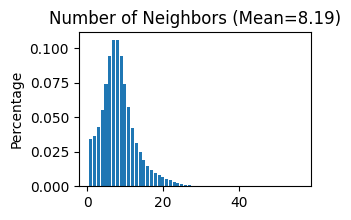

In [7]:
Cal_Spatial_Net(adata, rad_cutoff=20)
Stats_Spatial_Net(adata)

In [8]:
stagate_ = STAGATE(model_dir="D:\\Users\\lqlu\\work\\Data\\STABox_Data\\10X_Data", in_features=313, hidden_dims=[200, 30])

In [9]:
stagate_.train(adata, lr=1e-4, n_epochs=500, gradient_clip=5.0, use_net="Spatial_Net",
                resume=False, plot_consensus=True, n_clusters=6)

Size of Input:  (167782, 313)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:11<00:00,  3.79it/s]


AnnData object with n_obs × n_vars = 167782 × 313
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'Spatial_Net'
    obsm: 'spatial', 'STAGATE'

In [10]:
from stabox.pl.utils import mclust_R

In [11]:
adata = mclust_R(adata, 6)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


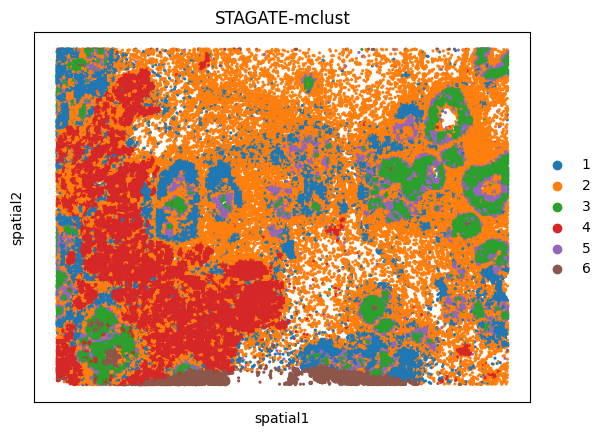

In [18]:
sc.pl.embedding(adata, basis='spatial',color='mclust', title='STAGATE-mclust', s=20, show=True)